# Language Model Demos

This notebook explores the zero shot capabilities of the OpenAI multi-transformer language model in "Improving Language Understanding by Generative Pre-Training" adapted from their original code. In other words, the model is performing predictions with absolutely no training on these datasets.  On sentiment analysis, it achieves 73% just by appending the word "very" to reviews and seeing if the language model predicts "positive" or "negative". On commonsense reasoning and pronoun disambiguation, it can actually achieve results (57%, 67%) competitive with the previous state of the art (52.8%, 66.7%) by predicting the sentence with the lowest average token loss. 

Even though Google Brain recently surpassed these results with another language model (63.7%, 70%) in "A Simple Method for Commonsense Reasoning", their model is considerably massive. It is a 200GB ensemble of 14 models trained on a much larger dataset (Billion words, Gutenberg, CommonCrawl, SQuAD etc). In comparison, OpenAI's model which is <0.5GB is size is trained on 7000 books from which one could estimate a total of just 700 million words (100000 words per book). In addition, the Google Brain model trains on a additional custom dataset. Hence, it would be exciting to see what the OpenAI model is capable of, if given the same advantages.

On another note, these language models are still struggling compared to humans on relatively simple text tasks like sentiment analysis or commonsense reasoning, which leads one to speculate if they are just 'brute-forcing' it, especially upon closer inspection of the results.

## Datasets Tested:

1.   [SST2 - Sentiment Analysis](https://github.com/AcademiaSinicaNLPLab/sentiment_dataset)
2.   [Winograd Schemas - Commonsense Reasoning](https://cs.nyu.edu/faculty/davise/papers/WinogradSchemas/WS.html)
3.   [PDP - Pronoun Disambiguation](http://commonsensereasoning.org/disambiguation.html)
4.   [CoLA - Linguistic Acceptability](https://nyu-mll.github.io/CoLA/)

**OpenAI Paper**: https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf

**Google Brain Paper**: https://arxiv.org/pdf/1806.02847.pdf

In [1]:
import os, sys
import re, json, unicodedata
import math, time, random 
import numpy as np

import tensorflow as tf
from tensorflow.python.framework import function

from functools import partial

In [2]:
finetune_repo = os.path.join(os.path.expanduser("~"), "Documents", "nlpdev", "finetune-transformer-lm")
os.path.exists(finetune_repo)

True

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [4]:
if not os.path.exists(finetune_repo):
    !git clone -q https://github.com/openai/finetune-transformer-lm.git {os.path.pardir(finetune_repo)}

In [5]:
# !pip install -q joblib tqdm ftfy spacy
# !pip install -q joblib ftfy spacy
# if not os.path.exists('/usr/local/lib/python3.6/dist-packages/spacy/data/en'):
#     !python -m spacy download en

## Utils

In [6]:
import xml.etree.ElementTree as etree
import ftfy, spacy
#from tqdm import tqdm
#tqdm = lambda x: x

def parse_xml(file):
    tree = etree.parse(file)
    root = tree.getroot()
    problems = list()
    for original_problem in root.getchildren():
        problem = dict()
        for info in original_problem.getchildren():
            if info.tag == 'answers':
                answers = info.getchildren()
                answer_list = [answer.text.strip() for answer in answers]
                problem['answers'] = answer_list
            elif info.tag == 'text':
                texts = info.getchildren()
                text_dict = dict()
                for text1 in texts:
                    text_dict[text1.tag] = text1.text.replace('\n', ' ').strip()
                problem['text'] = text_dict
            elif info.tag == 'correctAnswer':
                problem[info.tag] = info.text.strip().replace('.', '')
        problems.append(problem)
    return problems

def get_pairs(word): # character bigrams as tuples
    """
    Return set of symbol pairs in a word.
    word is represented as tuple of symbols (symbols being variable-length strings)
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs

def text_standardize(text):
    """
    fixes some issues the spacy tokenizer had on books corpus
    also does some whitespace standardization
    """
    text = text.replace('—', '-')
    text = text.replace('–', '-')
    text = text.replace('―', '-')
    text = text.replace('…', '...')
    text = text.replace('´', "'")
    text = re.sub('''(-+|~+|!+|"+|;+|\?+|\++|,+|\)+|\(+|\\+|\/+|\*+|\[+|\]+|}+|{+|\|+|_+)''', r' \1 ', text)
    text = re.sub('\s*\n\s*', ' \n ', text)
    text = re.sub('[^\S\n]+', ' ', text)
    return text.strip()

class TextEncoder(object):
    """
    mostly a wrapper for a public python bpe tokenizer
    """

    def __init__(self, encoder_path, bpe_path):
        self.nlp = spacy.load('en', disable=['parser', 'tagger', 'ner', 'textcat'])
        self.encoder = json.load(open(encoder_path))
        self.decoder = {v:k for k,v in self.encoder.items()}
        merges = open(bpe_path).read().split('\n')[1:-1]
        merges = [tuple(merge.split()) for merge in merges]
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {}

    def bpe(self, token):
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        if token in self.cache:
            return self.cache[token]
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        if word == '\n  </w>':
            word = '\n</w>'
        self.cache[token] = word
        return word

    def encode(self, texts, verbose=True):
        texts_tokens = []
        if verbose:
            #for text in tqdm(texts, ncols=80, leave=False):
            for text in texts:
                text = self.nlp(text_standardize(ftfy.fix_text(text)))
                text_tokens = []
                for token in text:
                    text_tokens.extend([self.encoder.get(t, 0) for t in self.bpe(token.text.lower()).split(' ')])
                texts_tokens.append(text_tokens)
        else:
            for text in texts:
                text = self.nlp(text_standardize(ftfy.fix_text(text)))
                text_tokens = []
                for token in text:
                    text_tokens.extend([self.encoder.get(t, 0) for t in self.bpe(token.text.lower()).split(' ')])
                texts_tokens.append(text_tokens)
        return texts_tokens

In [7]:
def encode_dataset(*splits, encoder):  # convert strings to token indices
    encoded_splits = []
    for split in splits[0]:
        fields = []
        for field in split:
            if isinstance(field[0], str):
                field = encoder.encode(field)
            fields.append(field)
        encoded_splits.append(fields)
    return encoded_splits

def shape_list(x):
    """
    deal with dynamic shape in tensorflow cleanly
    """
    ps = x.get_shape().as_list()
    ts = tf.shape(x)
    return [ts[i] if ps[i] is None else ps[i] for i in range(len(ps))]

def np_softmax(x, t=1):
    x = x/t
    x = x - np.max(x, axis=-1, keepdims=True)
    ex = np.exp(x)
    return ex/np.sum(ex, axis=-1, keepdims=True)
    return f

def flatten(outer):
    return [el for inner in outer for el in inner]

def get_ema_if_exists(v, gvs):
    name = v.name.split(':')[0]
    ema_name = name+'/ExponentialMovingAverage:0'
    ema_v = [v for v in gvs if v.name == ema_name]
    if len(ema_v) == 0:
        ema_v = [v]
    return ema_v[0]

def get_ema_vars(*vs):
    if tf.get_variable_scope().reuse:
        gvs = tf.global_variables()
        vs = [get_ema_if_exists(v, gvs) for v in vs]
    if len(vs) == 1:
        return vs[0]
    else:
        return vs

def assign_to_gpu(gpu=0, ps_dev="/device:CPU:0"):
    def _assign(op):
        node_def = op if isinstance(op, tf.NodeDef) else op.node_def
        if node_def.op == "Variable":
            return ps_dev
        else:
            return "/gpu:%d" % gpu
    return _assign

def average_grads(tower_grads):
    def average_dense(grad_and_vars):
        if len(grad_and_vars) == 1:
            return grad_and_vars[0][0]

        grad = grad_and_vars[0][0]
        for g, _ in grad_and_vars[1:]:
            grad += g
        return grad / len(grad_and_vars)

    def average_sparse(grad_and_vars):
        if len(grad_and_vars) == 1:
            return grad_and_vars[0][0]

        indices = []
        values = []
        for g, _ in grad_and_vars:
            indices += [g.indices]
            values += [g.values]
        indices = tf.concat(indices, 0)
        values = tf.concat(values, 0)
        return tf.IndexedSlices(values, indices, grad_and_vars[0][0].dense_shape)

    average_grads = []
    for grad_and_vars in zip(*tower_grads):
        if grad_and_vars[0][0] is None:
            grad = None
        elif isinstance(grad_and_vars[0][0], tf.IndexedSlices):
            grad = average_sparse(grad_and_vars)
        else:
            grad = average_dense(grad_and_vars)
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
    return average_grads

## Data

In [9]:
# Sentiment Dataset
if not os.path.exists('sentiment_dataset'):
    !git clone -q https://github.com/AcademiaSinicaNLPLab/sentiment_dataset.git
# Winograd Schema Dataset (285 questions in XML)
if not os.path.isfile('WSCollection.xml'):
    !wget -q cs.nyu.edu/faculty/davise/papers/WinogradSchemas/WSCollection.xml
# Pronoun Disambiguation (PDP) Dataset (60 questions in XML)
if not os.path.isfile('PDPChallenge.xml'):
    !wget -q cs.nyu.edu/faculty/davise/papers/PDPChallenge.xml
# Corpus of Language Acceptability (CoLA)
if not os.path.isfile('cola_public.zip'):
    !wget -q https://nyu-mll.github.io/CoLA/cola_public.zip
    !unzip -n cola_public.zip

In [8]:
# Pretrained Language Model data
encoder_path = os.path.join(finetune_repo, 'model/encoder_bpe_40000.json')
bpe_path = os.path.join(finetune_repo, 'model/vocab_40000.bpe' ) 
encoder = TextEncoder(encoder_path, bpe_path) # words and byte pairs
n_vocab = len(encoder.encoder) # 40478

In [10]:
# Prepare SST2 Sentiment Analysis Dataset
with open('sentiment_dataset/data/stsa.binary.test') as file:
    sst = [(line[0], line[1:].strip() + ' very') for line in file]
   
Y_sst, X_sst = zip(*sst[:100])  # limit to 100 for speed of demo
Y_sst = [int(i) for i in Y_sst]

X_tok_sst = [encoder.encode([x])[0] for x in X_sst]

!head sentiment_dataset/data/stsa.binary.train

1 a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films
0 apparently reassembled from the cutting-room floor of any given daytime soap .
0 they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science-fiction elements of bug-eyed monsters and futuristic women in skimpy clothes .
1 this is a visually stunning rumination on love , memory , history and the war between art and commerce .
1 jonathan parker 's bartleby should have been the be-all-end-all of the modern-office anomie films .
1 campanella gets the tone just right -- funny in the middle of sad in the middle of hopeful .
0 a fan film that for the uninitiated plays better on video with the sound turned down .
1 béart and berling are both superb , while huppert ... is magnificent .
0 a little less extreme than in the past , with longer exposition sequences between them , and with fewer gags to break

In [11]:
# Prepare Winograd Schema dataset
# Restricted to binary questions only
# Sorted by length for convenience of demo
problems = parse_xml('WSCollection.xml')
problems = [problem for problem in problems if len(problem['answers']) == 2]
problems = sorted(problems, key = lambda x: len(x['text']['txt1'] + x['text']['txt2']))

X_front = []; X_back = []; Y_wino = []
ans_dict = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4}

for problem in problems:
    ans_list_front = []
    ans_list_back = []
    front = problem['text']['txt1']
    back = problem['text']['txt2']
    for ans in problem['answers']:
        ans_list_front.append(' '.join([front, ans]))
        ans_list_back.append(back)
    X_front.append(ans_list_front)
    X_back.append(ans_list_back)
    Y_wino.append(ans_dict[problem['correctAnswer']])
    
X_front_tok = [[encoder.encode([ans])[0] for ans in x] for x in X_front]
X_back_tok = [[encoder.encode([ans])[0] for ans in x] for x in X_back]

front_lengths_wino = [[len(ans) for ans in x] for x in X_front_tok]

X_tok_wino = [[X_front_tok[i][j] + X_back_tok[i][j] 
          for j in range(len(X_front_tok[i]))] 
          for i in range(len(X_front_tok))]

problems[:3]

[{'answers': ['The fish', 'The worm'],
  'correctAnswer': 'B',
  'text': {'pron': 'It',
   'txt1': 'The fish ate the worm.',
   'txt2': 'was tasty.'}},
 {'answers': ['John', 'Bill'],
  'correctAnswer': 'A',
  'text': {'pron': 'him',
   'txt1': 'John hired Bill to take care of',
   'txt2': '.'}},
 {'answers': ['The fish', 'The worm'],
  'correctAnswer': 'A',
  'text': {'pron': 'It',
   'txt1': 'The fish ate the worm.',
   'txt2': 'was hungry.'}}]

In [13]:
# Prepare PDP dataset
# Restricted to binary questions only
# Sorted by length for convenience of demo
problems = parse_xml('PDPChallenge.xml')
problems = [problem for problem in problems if len(problem['answers']) == 2]
problems = sorted(problems, key = lambda x: len(x['text']['txt1'] + x['text']['txt2']))

X_front = []; X_back = []; Y_pdp = []
ans_dict = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4}

for problem in problems:
    ans_list_front = []
    ans_list_back = []
    front = problem['text']['txt1']
    back = problem['text']['txt2']
    for ans in problem['answers']:
        ans_list_front.append(' '.join([front, ans]))
        ans_list_back.append(back)
    X_front.append(ans_list_front)
    X_back.append(ans_list_back)
    Y_pdp.append(ans_dict[problem['correctAnswer']])
    
X_front_tok = [[encoder.encode([ans])[0] for ans in x] for x in X_front]
X_back_tok = [[encoder.encode([ans])[0] for ans in x] for x in X_back]

front_lengths_pdp = [[len(ans) for ans in x] for x in X_front_tok]

X_tok_pdp = [[X_front_tok[i][j] + X_back_tok[i][j] 
          for j in range(len(X_front_tok[i]))] 
          for i in range(len(X_front_tok))]

problems[:3]

[{'answers': ['Mark', 'Harry'],
  'correctAnswer': 'A',
  'text': {'pron': 'he',
   'txt1': 'Of one thing Mark was sure. Harry knew much less than',
   'txt2': 'did.'}},
 {'answers': ['Mark', 'Warren'],
  'correctAnswer': 'A',
  'text': {'pron': 'his',
   'txt1': "So Mark slept. It was daylight when he woke with Warren's hand upon",
   'txt2': 'shoulder.'}},
 {'answers': ['food', 'time'],
  'correctAnswer': 'A',
  'text': {'pron': 'it',
   'txt1': 'I sallied out for a bit of food, more to pass the time than because I wanted',
   'txt2': '.'}}]

In [12]:
with open('public/raw/in_domain_dev.tsv') as file:
    cola = [[line.split('\t')[i].strip() for i in [1, 3]] for line in file]
    
Y_cola, X_cola = zip(*cola)
Y_cola = [int(y) for y in Y_cola]

X_tok_cola = [encoder.encode([x])[0] for x in X_cola]

cola[:10]

[['1', 'The sailors rode the breeze clear of the rocks.'],
 ['1', 'The weights made the rope stretch over the pulley.'],
 ['1', 'The mechanical doll wriggled itself loose.'],
 ['1', 'If you had eaten more, you would want less.'],
 ['0', 'As you eat the most, you want the least.'],
 ['0', 'The more you would want, the less you would eat.'],
 ['0', 'I demand that the more John eat, the more he pays.'],
 ['1', 'Mary listens to the Grateful Dead, she gets depressed.'],
 ['1', 'The angrier Mary got, the more she looked at pictures.'],
 ['1', 'The higher the stakes, the lower his expectations are.']]

In [14]:
def preprocess(tokens, n_ctx, front_length=0, mode='all'):
    # X is numpy array of tokens with positioning tokens
    # M is masking array; the loss is only calculated from the positions with ones
    X = np.zeros((1, 1, n_ctx, 2), dtype=np.int32)
    M = np.zeros((1, 1, n_ctx), dtype=np.float32)
    X[:, :, :len(tokens), 0] = tokens
    # We manipulate the masking in order to restrict the scoring of losses
    # Inspired by "A Simple Method for Commonsense Reasoning"
    # Calculating losses for only the text after the insertion scores better
    if mode == 'front':
        M[:, :, :front_length] = 1
    elif mode == 'back' or mode == 'all':
        M[:, :, front_length:len(tokens)] = 1, 
    X[:, :, :, 1] = np.arange(n_vocab, n_vocab + n_ctx)
    return X, M

In [15]:
# Get various contexts (for masking, etc)
n_ctx_sst = max(len(x) for x in X_tok_sst)  # 55
n_ctx_wino = max([max([len(ans) for ans in x]) for x in X_tok_wino])  # 46
n_ctx_pdp = max([max([len(ans) for ans in x]) for x in X_tok_pdp])  # 64
n_ctx_cola = max(len(x) for x in X_tok_cola)  # 29
n_ctx = max(n_ctx_sst, n_ctx_wino, n_ctx_pdp, n_ctx_cola)

X_pre_sst = [preprocess(x, n_ctx, mode='all') for x in X_tok_sst]


X_pre_all_wino = [[preprocess(X_tok_wino[i][j], n_ctx, mode='all') 
          for j in range(len(X_tok_wino[i]))] 
          for i in range(len(X_tok_wino))]
X_pre_back_wino = [[preprocess(X_tok_wino[i][j], n_ctx, front_lengths_wino[i][j], mode='back') 
                    for j in range(len(X_tok_wino[i]))] 
                    for i in range(len(X_tok_wino))]
X_pre_front_wino = [[preprocess(X_tok_wino[i][j], n_ctx, front_lengths_wino[i][j], mode='front') 
                     for j in range(len(X_tok_wino[i]))] 
                     for i in range(len(X_tok_wino))]


X_pre_all_pdp = [[preprocess(X_tok_pdp[i][j], n_ctx, mode='all') 
          for j in range(len(X_tok_pdp[i]))] 
          for i in range(len(X_tok_pdp))]
X_pre_back_pdp = [[preprocess(X_tok_pdp[i][j], n_ctx, front_lengths_pdp[i][j], mode='back') 
                    for j in range(len(X_tok_pdp[i]))] 
                    for i in range(len(X_tok_pdp))]
X_pre_front_pdp = [[preprocess(X_tok_pdp[i][j], n_ctx, front_lengths_pdp[i][j], mode='front') 
                     for j in range(len(X_tok_pdp[i]))] 
                     for i in range(len(X_tok_pdp))]


X_pre_cola = [preprocess(x, n_ctx, mode='all') for x in X_tok_cola]

## Model

In [16]:
import joblib
import argparse

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef

def shape_list(x):
    """
    deal with dynamic shape in tensorflow cleanly
    """
    ps = x.get_shape().as_list()
    ts = tf.shape(x)
    return [ts[i] if ps[i] is None else ps[i] for i in range(len(ps))]

def get_ema_vars(*vs):
    if tf.get_variable_scope().reuse:
        gvs = tf.global_variables()
        vs = [get_ema_if_exists(v, gvs) for v in vs]
    if len(vs) == 1:
        return vs[0]
    else:
        return vs

def warmup_cosine(x, warmup=0.002):
    s = tf.cast(x <= warmup, tf.float32)
    return s*(x/warmup) + (1-s)*(0.5 * (1 + tf.cos(math.pi * x)))

def warmup_constant(x, warmup=0.002):
    s = tf.cast(x <= warmup, tf.float32)
    return s*(x/warmup) + (1-s)*1

def warmup_linear(x, warmup=0.002):
    s = tf.cast(x <= warmup, tf.float32)
    return (s*(x/warmup) + (1-s))*(1-x)

schedules = {
    'warmup_cosine':warmup_cosine,
    'warmup_constant':warmup_constant,
    'warmup_linear':warmup_linear,
}

def adam(params, grads, lr, schedule, t_total, 
         b1=0.9, b2=0.999, e=1e-8, l2=0, vector_l2=False, max_grad_norm=-1, 
         **kwargs):
    """
    adam with weight decay fix
    """
    t = tf.Variable(0, dtype=tf.float32, trainable=False)
    tt = t+1
    updates = [t.assign(tt)]
    if max_grad_norm > 0:
        grads, _ = tf.clip_by_global_norm(grads, max_grad_norm)
    for p, g in zip(params, grads):
        if p is None or g is None:
            print("can't train", p.name, g)
        else:
            if isinstance(g, tf.IndexedSlices):
                g = tf.convert_to_tensor(g)
            m = tf.Variable(p*0, dtype=tf.float32, trainable=False)
            v = tf.Variable(p*0, dtype=tf.float32, trainable=False)
            lrt = lr*tf.sqrt(1-b2**tt)/(1-b1**tt)
            lrt *= schedule(t/t_total)
            mt = b1*m + (1-b1)*g
            vt = b2*v + (1-b2)*g*g
            if (len(p.get_shape()) > 1 or vector_l2) and l2 > 0:
                pt = p - lrt * (mt / (tf.sqrt(vt) + e) + l2*p)
            else:
                pt = p - lrt * (mt / (tf.sqrt(vt) + e))
            updates.extend([m.assign(mt), v.assign(vt), p.assign(pt)])
    return tf.group(*updates)

def gelu(x):
    return 0.5*x*(1+tf.tanh(math.sqrt(2/math.pi)*(x+0.044715*tf.pow(x, 3))))

def swish(x):
    return x*tf.nn.sigmoid(x)

opt_fns = {
    'adam':adam,
}

act_fns = {
    'relu':tf.nn.relu,
    'swish':swish,
    'gelu':gelu
}

lr_schedules = {
    'warmup_cosine':warmup_cosine,
    'warmup_linear':warmup_linear,
    'warmup_constant':warmup_constant,
}

def _norm(x, g=None, b=None, e=1e-5, axis=[1]):
    u = tf.reduce_mean(x, axis=axis, keepdims=True)
    s = tf.reduce_mean(tf.square(x-u), axis=axis, keepdims=True)
    x = (x - u) * tf.rsqrt(s + e)
    if g is not None and b is not None:
        x = x*g + b
    return x

def norm(x, scope, axis=[-1]):
    with tf.variable_scope(scope):
        n_state = shape_list(x)[-1]
        g = tf.get_variable("g", [n_state], initializer=tf.constant_initializer(1))
        b = tf.get_variable("b", [n_state], initializer=tf.constant_initializer(0))
        g, b = get_ema_vars(g, b)
        return _norm(x, g, b, axis=axis)

def dropout(x, pdrop, train):
    if train and pdrop > 0:
        x = tf.nn.dropout(x, 1-pdrop)
    return x

def mask_attn_weights(w):
    n = shape_list(w)[-1]
    b = tf.matrix_band_part(tf.ones([n, n]), -1, 0)
    b = tf.reshape(b, [1, 1, n, n])
    w = w*b + -1e9*(1-b)
    return w

def _attn(q, k, v, train=False, scale=False):
    w = tf.matmul(q, k)

    if scale:
        n_state = shape_list(v)[-1]
        w = w*tf.rsqrt(tf.cast(n_state, tf.float32))

    w = mask_attn_weights(w)
    w = tf.nn.softmax(w)

    w = dropout(w, attn_pdrop, train)

    a = tf.matmul(w, v)
    return a

def split_states(x, n):
    x_shape = shape_list(x)
    m = x_shape[-1]
    new_x_shape = x_shape[:-1]+[n, m//n]
    return tf.reshape(x, new_x_shape)

def merge_states(x):
    x_shape = shape_list(x)
    new_x_shape = x_shape[:-2]+[np.prod(x_shape[-2:])]
    return tf.reshape(x, new_x_shape)

def split_heads(x, n, k=False):
    if k:
        return tf.transpose(split_states(x, n), [0, 2, 3, 1])
    else:
        return tf.transpose(split_states(x, n), [0, 2, 1, 3])

def merge_heads(x):
    return merge_states(tf.transpose(x, [0, 2, 1, 3]))

def conv1d(x, scope, nf, rf, 
           w_init=tf.random_normal_initializer(stddev=0.02), 
           b_init=tf.constant_initializer(0), pad='VALID', train=False):
    with tf.variable_scope(scope):
        nx = shape_list(x)[-1]
        w = tf.get_variable("w", [rf, nx, nf], initializer=w_init)
        b = tf.get_variable("b", [nf], initializer=b_init)
        if rf == 1: #faster 1x1 conv
            c = tf.reshape(tf.matmul(tf.reshape(x, [-1, nx]), 
                                     tf.reshape(w, [-1, nf]))+b, 
                           shape_list(x)[:-1]+[nf])
        else: #was used to train LM
            c = tf.nn.conv1d(x, w, stride=1, padding=pad)+b
        return c

def attn(x, scope, n_state, n_head, train=False, scale=False):
    assert n_state%n_head==0
    with tf.variable_scope(scope):
        c = conv1d(x, 'c_attn', n_state*3, 1, train=train)
        q, k, v = tf.split(c, 3, 2)
        q = split_heads(q, n_head)
        k = split_heads(k, n_head, k=True)
        v = split_heads(v, n_head)
        a = _attn(q, k, v, train=train, scale=scale)
        a = merge_heads(a)
        a = conv1d(a, 'c_proj', n_state, 1, train=train)
        a = dropout(a, resid_pdrop, train)
        return a

def mlp(x, scope, n_state, train=False):
    with tf.variable_scope(scope):
        nx = shape_list(x)[-1]
        act = act_fns[afn]
        h = act(conv1d(x, 'c_fc', n_state, 1, train=train))
        h2 = conv1d(h, 'c_proj', nx, 1, train=train)
        h2 = dropout(h2, resid_pdrop, train)
        return h2

def block(x, scope, train=False, scale=False):
    with tf.variable_scope(scope):
        nx = shape_list(x)[-1]
        a = attn(x, 'attn', nx, n_head, train=train, scale=scale)
        n = norm(x+a, 'ln_1')
        m = mlp(n, 'mlp', nx*4, train=train)
        h = norm(n+m, 'ln_2')
        return h

def embed(X, we):
    e = tf.gather(we, X)
    h = tf.reduce_sum(e, 2)
    return h

    
def model(X, M, train=False, reuse=False):
    with tf.variable_scope('model', reuse=reuse):
        we = tf.get_variable("we", [n_vocab + n_ctx, n_embd], 
                             initializer=tf.random_normal_initializer(stddev=0.02))
        we = dropout(we, embd_pdrop, train)

        X = tf.reshape(X, [-1, n_ctx, 2])  # flatten to 1D
        M = tf.reshape(M, [-1, n_ctx])

        h = embed(X, we)
        for layer in range(n_layer): # 12 transformer block architecture
            h = block(h, 'h%d'%layer, train=train, scale=True)

        lm_h = tf.reshape(h[:, :-1], [-1, n_embd])
        lm_logits = tf.matmul(lm_h, we, transpose_b=True)
        lm_losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=lm_logits, labels=tf.reshape(X[:, 1:, 0], [-1]))
        lm_losses = tf.reshape(lm_losses, [shape_list(X)[0], shape_list(X)[1]-1])
        lm_losses = tf.reduce_sum(lm_losses*M[:, 1:], 1)/tf.reduce_sum(M[:, 1:], 1)

        return lm_h, lm_logits, lm_losses

In [17]:
tf.reset_default_graph()

lr = 6.25e-6
lr_warmup = 0.002
lr_schedule = 'warmup_linear'
n_iter = 3
n_batch = 4
max_grad_norm = 1
n_embd = 768
n_layer = 12
n_head = 12
embd_pdrop = 0.1
attn_pdrop = 0.1
resid_pdrop = 0.1
l2 = 0.01
vector_l2 = True
opt = 'adam'
afn = 'gelu'
n_transfer = 12
lm_coef = 0.5
b1 = 0.9
b2 = 0.999
e = 1e-8
n_special = 0  # no special symbols like START/END needed
n_gpu = 1

X = tf.placeholder(tf.int32, [None, 1, n_ctx, 2])
M = tf.placeholder(tf.float32, [None, 1, n_ctx])

In [18]:
# Build Language Model itself
h, logits, losses = model(X, M, train=False, reuse=False)

In [19]:
# Initialise Language Model
params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, ".*model.*")
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(tf.global_variables_initializer())

In [20]:
# Put in the pretrained saved weights
shapes = json.load(open(os.path.join(finetune_repo, 'model/params_shapes.json')))
offsets = np.cumsum([np.prod(shape) for shape in shapes])
init_params = [np.load(os.path.join(finetune_repo, 'model/params_{}.npy').format(n)) for n in range(10)]
init_params = np.split(np.concatenate(init_params, 0), offsets)[:-1]
init_params = [param.reshape(shape) for param, shape in zip(init_params, shapes)]
init_params[0] = init_params[0][:n_ctx]
init_params[0] = np.concatenate([init_params[1], (np.random.randn(0, n_embd)*0.02).astype(np.float32), init_params[0]], 0)
del init_params[1]

n_transfer = 1 + n_transfer * 12
_ = sess.run([p.assign(ip) for p, ip in zip(params[:n_transfer], init_params[:n_transfer])])

## Test SST2 - Sentiment Classifier

In [21]:
pos = encoder.encode(['positive'])[0][0]
neg = encoder.encode(['negative'])[0][0]
pos, neg

(6353, 9503)

In [22]:
X_logits = [[sess.run(logits, {X:xx, M:m})][0] for xx,m in X_pre_sst]

In [23]:
lengths = [len(x) for x in X_tok_sst]

In [24]:
X_probs_pos = [X_logits[i][lengths[i]-2, pos] for i in range(len(X_logits))]
X_probs_neg = [X_logits[i][lengths[i]-2, neg] for i in range(len(X_logits))]

In [25]:
X_preds = [int(prob_pos > prob_neg) for prob_pos, prob_neg in zip(X_probs_pos, X_probs_neg)]

In [26]:
accuracy_score(Y_sst, X_preds)  # 73% if full dataset is tested

0.68

In [27]:
def sentiment_test(review):
    toks = encoder.encode([review + ' very'])[0]
    length = len(toks)
    x, m = preprocess(toks, n_ctx, mode='all')
    test_logits = sess.run(logits, {X:x, M:m})
    # Test position following input for Positive vs Negative as a word
    prob_pos = test_logits[length - 2, pos]
    prob_neg = test_logits[length - 2, neg]
    return prob_pos > prob_neg
  
def print_sentiment(review):
    is_positive = sentiment_test(review)
    print("%s = %s" % (review, ("Positive" if is_positive else "Negative") ))
 
print_sentiment("I loved this movie.")
print_sentiment("I hated this movie.")

I loved this movie. = Positive
I hated this movie. = Negative


## Test Winograd Schema - Commonsense Reasoning

In [31]:
def score_using_lm(txt):
    tokens = encoder.encode([txt])[0]
    x, m = preprocess(tokens, n_ctx, mode='all')
    return "%s - %.4f" % (txt, sess.run(losses, {X:x, M:m})[0])

In [32]:
print(score_using_lm('the cat sat on the mat'))
print(score_using_lm('the dog sat on the mat'))  # Best = Dogs!?!?
print(score_using_lm('the mat sat on the dog'))
print(score_using_lm('mat the on sat dog the'))  # Should be worst

the cat sat on the mat - 5.2356
the dog sat on the mat - 5.0519
the mat sat on the dog - 6.5233
mat the on sat dog the - 9.1620


In [33]:
def stats_for_test_window(arr, Y_target):
    X_losses = [ [sess.run(losses, {X:xx, M:m})[0] for xx,m in x] 
                 for x in arr]
    X_preds = [np.argmin(x) for x in X_losses]

    print("Accuracy:%.2f%%, F1:%.2f%%, corrcoef:%.2f" % (
                    accuracy_score(Y_target, X_preds)*100., 
                    f1_score(Y_target, X_preds, average='weighted')*100.,
                    matthews_corrcoef(Y_target, X_preds),
    ))

In [34]:
# This computes the scores over whole of winograd sentence
stats_for_test_window(X_pre_all_wino, Y_wino)

Accuracy:55.44%, F1:54.11%, corrcoef:0.12


In [35]:
# This computes the scores over winograd sentence *after* replaced pronoun
stats_for_test_window(X_pre_back_wino, Y_wino)  # Probably better

Accuracy:57.19%, F1:56.99%, corrcoef:0.15


In [36]:
# This computes the scores over winograd sentence *before* replaced pronoun
stats_for_test_window(X_pre_front_wino, Y_wino)  # Probably worse...

Accuracy:52.98%, F1:51.86%, corrcoef:0.06


In [38]:
# Let's capture the logits for the 'whole sentence' version
X_logits = [[sess.run(logits, {X:xx, M:m}) for xx,m in x] for x in X_pre_all_wino]

In [39]:
def get_token_probs(logits, tokens):
    tokens = tokens[1:]
    return [logits[i, tokens[i]] for i in range(len(tokens))]

In [40]:
X_token_probs = [[get_token_probs(X_logits[i][j], X_tok_wino[i][j]) 
                  for j in range(len(X_logits[i]))] 
                  for i in range(len(X_logits))]

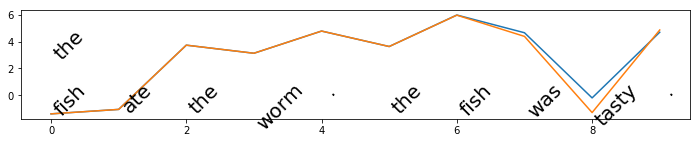

Options: ['Mark', 'Harry']
Predicted: Harry
Answer: Mark


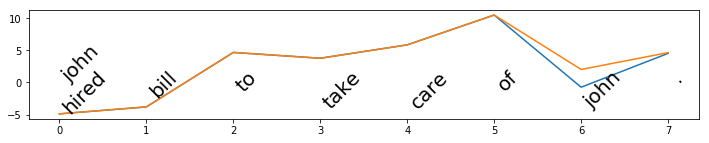

Options: ['Mark', 'Warren']
Predicted: Warren
Answer: Mark


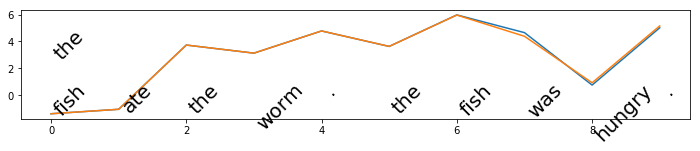

Options: ['food', 'time']
Predicted: food
Answer: food


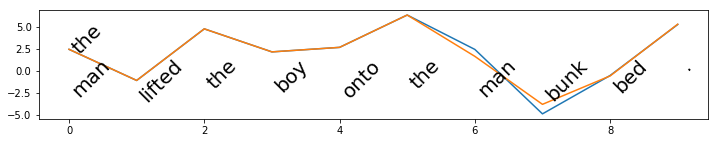

Options: ['Men', 'sons']
Predicted: Men
Answer: sons


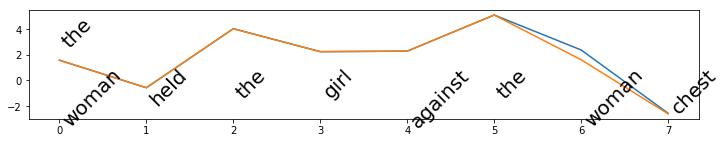

Options: ['Mama', 'Alice']
Predicted: Alice
Answer: Alice


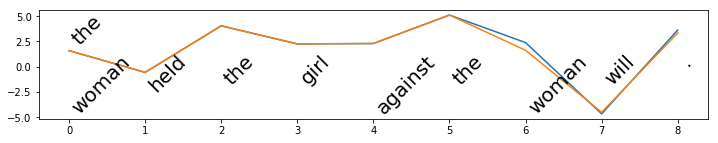

Options: ['Chester', 'Uncle Vernon']
Predicted: Uncle Vernon
Answer: Chester


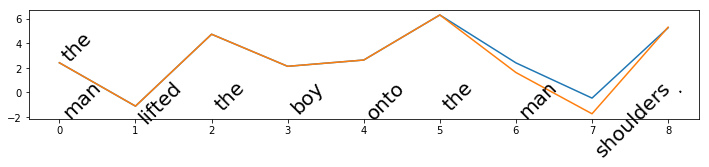

Options: ['Chester', 'Uncle Vernon']
Predicted: Uncle Vernon
Answer: Uncle Vernon


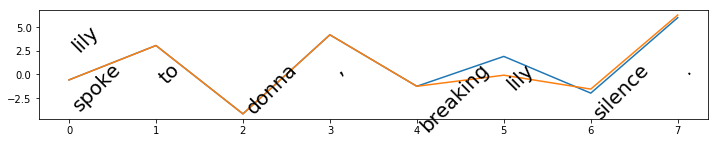

Options: ['Mama', 'Alice']
Predicted: Alice
Answer: Mama


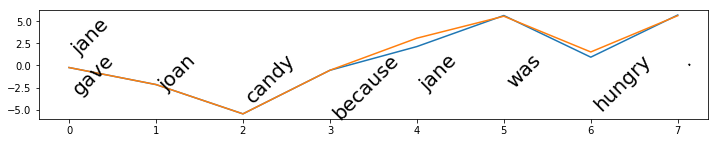

Options: ['tulip bulbs', 'hamburgers']
Predicted: tulip bulbs
Answer: tulip bulbs


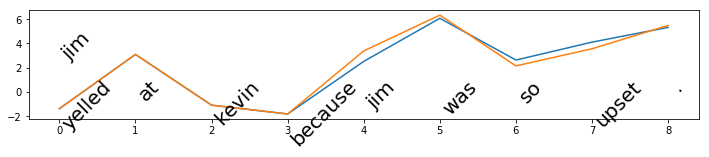

Options: ['politicians', 'settlers']
Predicted: politicians
Answer: politicians


In [42]:
# Make some nice charts
import matplotlib.pyplot as plt
%matplotlib inline  

rev = {k:v for v,k in encoder.encoder.items()}

for i in range(len(X_token_probs[:10])):
    plt.figure(figsize=(12,2))
    for j in range(len(X_token_probs[i])):
        plt.plot(X_token_probs[i][j])
    plt.annotate(rev[X_tok_wino[i][0][0]].replace('</w>', ''), xy=(0,4), rotation=45, size=20)
    for idx, tok in enumerate(X_tok_wino[i][0][1:]):
        plt.annotate(rev[tok].replace('</w>', ''), xy=(idx, 0), rotation=45, size=20)
    plt.show()
    options = problems[i]['answers']
    pred = options[X_preds[i]]
    answer = options[0 if problems[i]['correctAnswer'] == 'A' else 1]
    print('Options: {}\nPredicted: {}\nAnswer: {}'.format(options, pred, answer))

## Test PDP - Pronoun Disambiguation

In [43]:
# This computes the scores over whole of disambiguation sentence
stats_for_test_window(X_pre_all_pdp, Y_pdp)

Accuracy:62.22%, F1:62.81%, corrcoef:0.21


In [44]:
stats_for_test_window(X_pre_back_pdp, Y_pdp)

Accuracy:66.67%, F1:67.37%, corrcoef:0.35


In [45]:
stats_for_test_window(X_pre_front_pdp, Y_pdp)

Accuracy:53.33%, F1:54.06%, corrcoef:0.02


In [46]:
X_logits = [[sess.run(logits, {X:xx, M:m}) for xx,m in x] for x in X_pre_all_pdp]

In [47]:
def get_token_probs(logits, tokens):
    tokens = tokens[1:]
    return [logits[i, tokens[i]] for i in range(len(tokens))]

In [48]:
X_token_probs = [[get_token_probs(X_logits[i][j], X_tok_pdp[i][j]) 
                  for j in range(len(X_logits[i]))] 
                  for i in range(len(X_logits))]

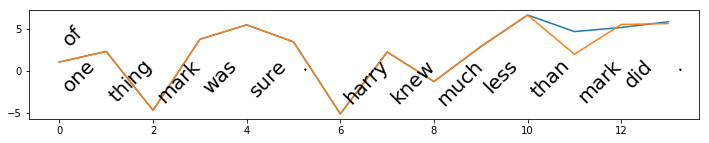

Options: ['Mark', 'Harry']
Predicted: Harry
Answer: Mark


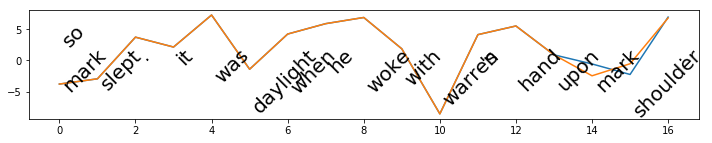

Options: ['Mark', 'Warren']
Predicted: Warren
Answer: Mark


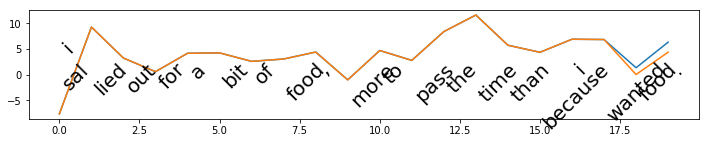

Options: ['food', 'time']
Predicted: food
Answer: food


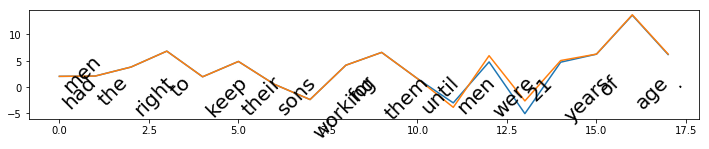

Options: ['Men', 'sons']
Predicted: Men
Answer: sons


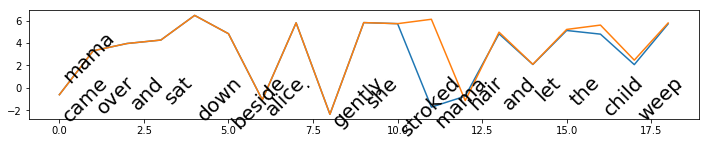

Options: ['Mama', 'Alice']
Predicted: Alice
Answer: Alice


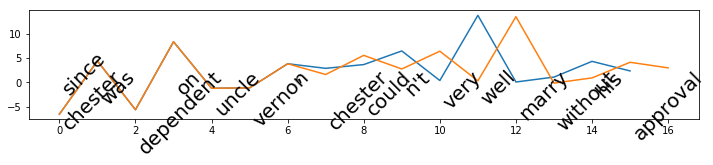

Options: ['Chester', 'Uncle Vernon']
Predicted: Uncle Vernon
Answer: Chester


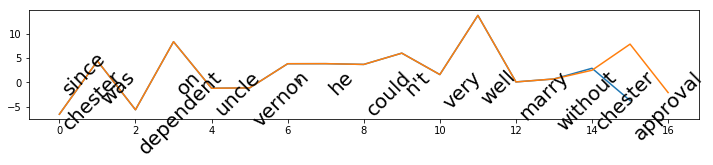

Options: ['Chester', 'Uncle Vernon']
Predicted: Uncle Vernon
Answer: Uncle Vernon


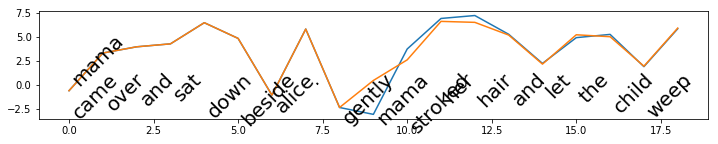

Options: ['Mama', 'Alice']
Predicted: Alice
Answer: Mama


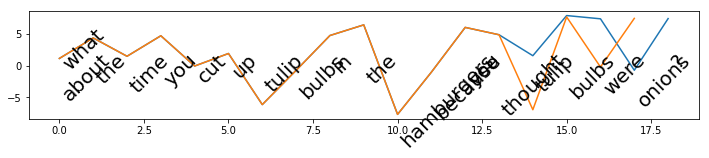

Options: ['tulip bulbs', 'hamburgers']
Predicted: tulip bulbs
Answer: tulip bulbs


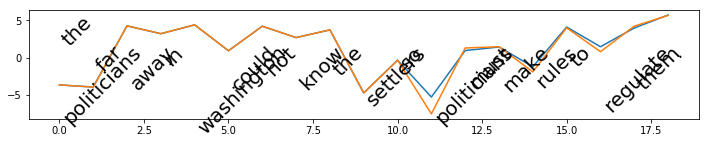

Options: ['politicians', 'settlers']
Predicted: politicians
Answer: politicians


In [49]:
import matplotlib.pyplot as plt
rev = {k:v for v,k in encoder.encoder.items()}

for i in range(len(X_token_probs[:10])):
    plt.figure(figsize=(12,2))
    for j in range(len(X_token_probs[i])):
        plt.plot(X_token_probs[i][j])
    plt.annotate(rev[X_tok_pdp[i][0][0]].replace('</w>', ''), xy=(0,4), rotation=45, size=20)
    for idx, tok in enumerate(X_tok_pdp[i][0][1:]):
        plt.annotate(rev[tok].replace('</w>', ''), xy=(idx, 0), rotation=45, size=20)
    plt.show()
    options = problems[i]['answers']
    pred = options[X_preds[i]]
    answer = options[0 if problems[i]['correctAnswer'] == 'A' else 1]
    print('Options: {}\nPredicted: {}\nAnswer: {}'.format(options, pred, answer))

## Test CoLA - Linguistic Acceptability

In [50]:
X_losses = [sess.run(losses, {X:xx, M:m})[0] for xx,m in X_pre_cola]

In [58]:
# Let's find a threshold that works well
thresholds_scores = []
thresholds = []
for threshold in np.linspace(min(X_losses)+0.1, max(X_losses), num=1000):
    preds = [int(x < threshold) for x in X_losses]
    thresholds_scores.append((threshold, matthews_corrcoef(Y_cola, preds)))

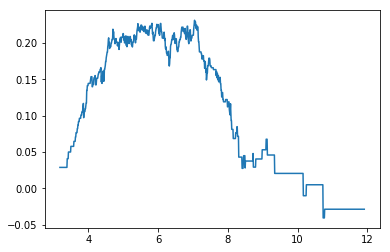

In [59]:
thresholds, scores = zip(*thresholds_scores)
plt.plot(thresholds, scores)
plt.show()

In [60]:
best_threshold_score = sorted(thresholds_scores, key=lambda x: x[1])[-1]
best_threshold_score

(7.048193952056381, 0.23134584636986708)

In [61]:
def acceptability_test(sentence, threshold):
    toks = encoder.encode([sentence])[0]
    x, m = preprocess(toks, n_ctx, mode='all')
    loss = sess.run(losses, {X:x, M:m})
    return loss < threshold  # True for Acceptable
  
def print_acceptability(sentence, threshold):
    is_acceptable = acceptability_test(sentence, threshold)
    print("%s = %s" % (sentence, ("Acceptable" if is_acceptable else "Unacceptable") ))
 
print_acceptability("This is a good sentence.", best_threshold_score[0])
print_acceptability("Sentence good a is this.", best_threshold_score[0])

This is a good sentence. = Acceptable
Sentence good a is this. = Unacceptable


In [62]:
# Get the predictions
preds = [int(x < best_threshold_score[0]) for x in X_losses]

In [63]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_cola, preds)

array([[ 50, 110],
       [ 44, 323]])

In [64]:
# Show the sentences that the LM thinks are BAD
for i in range(len(cola)):
    if preds[i] == 0:
        print(cola[i])

['1', 'The mechanical doll wriggled itself loose.']
['0', 'Who does John visit Sally because he likes?']
['1', 'You will believe Bob.']
['1', 'The tub leaked water.']
['1', 'Clearly, John probably will immediately learn French perfectly.']
['0', 'They represented seriously to the dean Mary as a genuine linguist.']
['0', 'Us love they.']
['0', 'Mary intended John to go abroad.']
['1', 'I remembered having kissed Mary.']
['1', "Mary claimed that eating cabbage, Holly shouldn't."]
['1', 'John often meets Mary.']
['0', 'The problem perceives easily.']
['1', 'We elected me.']
['0', 'A proof that the claim had been. made was giver that John had lied.']
['0', 'Himself is understood by Rutherford.']
['0', 'The proof this set is recursive is difficult.']
['0', 'The madrigals which Henry plays the lute and sings sound lousy.']
['0', "Which boy's did we elect guardian's employer president?"]
['0', 'Which hat did Mike quip that she never wore?']
['0', 'Which girl did Mike quip never wore this hat?